## Predictions Using Ridership Ship

### Brief Introduction

I was given the opportunity to poke around in this data set. Since the data is limited, I didn't get too deep in the weeds, but there's still some code in here worth hanging on to.

Some prelinary information about this dataset: We have pickups and dropoffs for vehicles over time. A pickup and dropoff are separate rows. There are only 4 people able to fit in a vehicle, there is no ride sharing, and hours are 7AM-7PM.

In [1]:
#### Preliminary Setup
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics


In [2]:
#import dataframes
pups = pd.read_csv("Data_Science_pickups.csv") #we'll use this dataset when making predictions using the classification tree
riders = pd.read_csv("Data_Science_site_ridership.csv")  #this is our dataset

### Exploratory Analysis and Basic Corrections

When I was just glancing over the first few hundred columns of the dataframe, I noticed that the time from the Google form (which is automatically created when the form is opened by the individual in the name column) does not always match the manual input. I am therefore assuming the user entered time is correct, but that the form was sometimes filled out after the fact.

Generally I begin data exploration by checking out all the possible values (which also has data cleaning benefits). 

In [3]:
#Check unique values of all columns
for col in riders:
    print(riders[col].unique())

['6/3/2021 13:08' '6/3/2021 13:31' '6/4/2021 11:06' ... '10/29/2021 17:26'
 '10/29/2021 17:48' '10/29/2021 17:55']
[ 1.  0.  3.  2. nan  8.  4.]
[ 0.  1.  3.  2. nan  8.  4.]
['Huron' 'Ontario' 'St. Claire' 'Michigan' 'Erie' 'Crystal' 'Beach'
 'Superior' 'Petoskey']
['Mantra' 'Wolverine' 'Lake' 'Cloud' 'Rock']
['13:05:00' '13:31:43' '11:03:00' '11:07:00' '12:40:00' '12:58:00'
 '17:07:19' '17:28:35' '15:20:31' '15:26:25' '15:34:21' '15:35:24'
 '7:57:00' '8:22:00' '11:15:00' '11:31:00' '13:09:00' '13:15:00'
 '14:28:00' '14:43:00' '15:08:00' '15:28:00' '17:23:00' '17:57:00'
 '18:05:00' '18:16:00' '18:21:00' '18:26:00' '7:50:00' '7:55:00' '8:12:00'
 '8:16:00' '11:12:00' '15:07:00' '15:11:00' '8:00:00' '8:05:00' '15:15:00'
 '15:21:00' '15:34:00' '16:50:00' '16:40:00' '15:46:00' '16:08:00'
 '17:54:00' '17:58:00' '7:15:00' '7:21:00' '11:48:00' '15:12:00' '8:18:00'
 '15:19:00' '15:24:00' '7:58:00' '8:04:00' '13:07:00' '13:25:00'
 '15:13:00' '17:15:00' '17:00:00' '10:29:00' '10:57:00' '10:59:00

We know there are 9 stops and 5 different vehicles. The data runs from the beginning of June through the end of October, and appears to not include weekends.

There's an issue with the pickup and dropoff numbers. Since only 4 people can fit in a vehicle, we know that the number 8 must be incorrect. In addition, there are some NaN values. Let's take a look at the 8 person rides.

In [4]:
#Check when pickup is 8
riders.loc[riders['pickup'] == 8]

,timestamp,pickup,dropoff,stop,vehicle,time,date
346,7/14/2021 16:45,8.0,0.0,Petoskey,Lake,16:44:00,7/14/2021
456,7/21/2021 14:18,8.0,0.0,St. Claire,Wolverine,14:18:00,7/21/2021


In [5]:
#Check when dropoff is 8
riders.loc[riders['dropoff'] == 8]

,timestamp,pickup,dropoff,stop,vehicle,time,date
348,7/14/2021 16:58,0.0,8.0,St. Claire,Lake,16:54:00,7/14/2021
457,7/21/2021 14:19,0.0,8.0,Beach,Wolverine,14:19:00,7/21/2021


Based on the fact that the same name and vehicle are used on the same date, I think it is reasonable to assume that these are the same ride. Since the number of rows is small compared to the size of our dataset, it seems reasonable to remove them. In a similar manner, I checked the NaN values, and they were pickup and dropoff values that should have been zeroes, so I will change them to zeroes.

In [6]:
#Drop rows for when dropoff == 8
riders = riders.drop(riders[riders.dropoff == 8].index)
riders = riders.fillna(0)

Lets take a look at the total number of pickups and dropoffs by stop.

In [7]:
#Sum of riders by stop
riders.groupby("stop").sum()

,pickup,dropoff
stop,,
Beach,245.0,612.0
Crystal,138.0,120.0
Erie,180.0,221.0
Huron,688.0,712.0
Michigan,584.0,389.0
Ontario,144.0,129.0
Petoskey,63.0,54.0
St. Claire,363.0,210.0
Superior,301.0,243.0


Some locations have noticably different amounts of pickups and dropoffs, and some locations have been used much more frequenly. I'm going to add a day of the week column, since I'll be looking at that in analysis anyway (as it seems like it could affect ridership), and to see what days of the week the data is from.

In [8]:
#Convert to datetime
riders['date'] = pd.to_datetime(riders['date'])
#Create weekday column
riders['weekday'] = riders['date'].dt.day_name()
#Count weekdays
riders['weekday'].value_counts()

Thursday     1006
Friday        932
Wednesday     871
Tuesday       819
Monday        722
Name: weekday, dtype: int64

There's noticably more riders on some days than others. 

### Plots

Plots are a great way to explore data. Even quick plots like the ones below, though not publication quality, can give a lot of information about a dataset and possible modeling options.

One thing to consider would be total ridership over time. A quick plot indicates it is increasing overall, but increasing and decreasing in shorter periods of time.

Text(0.5, 1.0, 'Daily Total of Pickups Over Time')

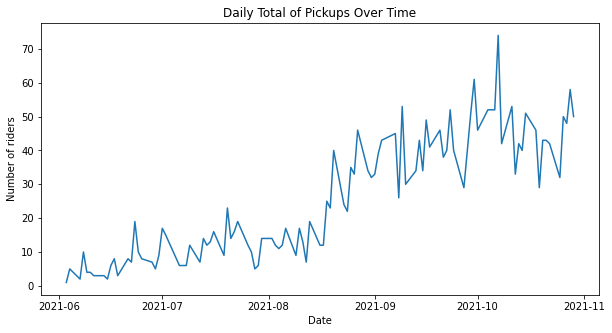

In [9]:
#Total riders per day plot
plt.plot(riders.groupby(['date'])['dropoff'].sum())
#Axis labels
plt.xlabel('Date') 
plt.ylabel('Number of riders')  
#Title
plt.title("Daily Total of Pickups Over Time")

A graph of cumulative ridership overtime by day indicates that the relationship is linear.

weekday
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
Name: cumsum_week_pick, dtype: object

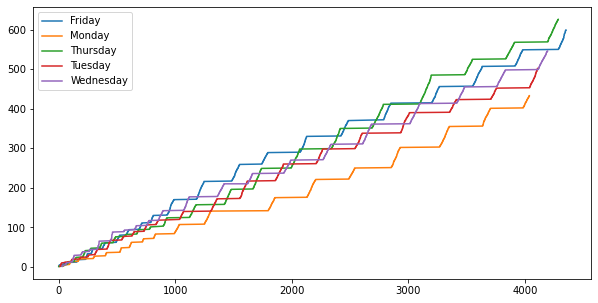

In [10]:
#Cumulative ridership by date
riders.set_index('date')
riders['cumsum_week_pick'] = riders.groupby('weekday')['pickup'].transform(pd.Series.cumsum)
riders.groupby(['weekday'])['cumsum_week_pick'].plot(legend=True)


In addition, cumulativen number of pickups and dropoffs would be of note. The graphs below show that some sites are infrequently used, as well as that the sites with more pickups do not have as many dropoffs.

Text(0.5, 1.0, 'Total Number of Pickups Over Time by Stop')

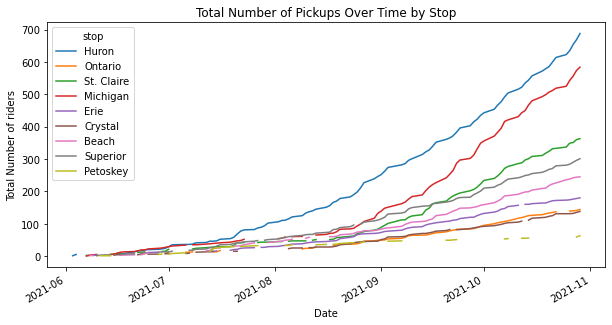

In [11]:
#Cumulative pickup of riders by stop plot
riders['cumsum_stop_pick'] = riders.groupby('stop')['pickup'].transform(pd.Series.cumsum)
riders_max = riders.groupby(['date','stop'], sort=False)['cumsum_stop_pick'].max()
riders_max.groupby(['date','stop']).sum().unstack().plot()
#Axis labels
plt.xlabel('Date') 
plt.ylabel('Total Number of riders')  
#Title
plt.title("Total Number of Pickups Over Time by Stop")

Text(0.5, 1.0, 'Total Number of Dropoffs Over Time by Stop')

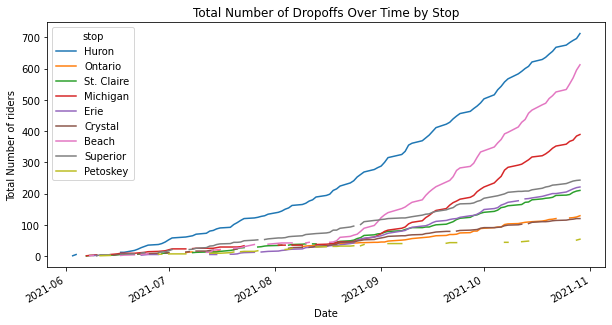

In [12]:
#Cumulative dropoff of riders by stop
riders['cumsum_stop_drop'] = riders.groupby('stop')['dropoff'].transform(pd.Series.cumsum)
riders_max = riders.groupby(['date','stop'], sort=False)['cumsum_stop_drop'].max()
riders_max.groupby(['date','stop']).sum().unstack().plot()
#Axis labels
plt.xlabel('Date') 
plt.ylabel('Total Number of riders')  
#Title
plt.title("Total Number of Dropoffs Over Time by Stop")

### Linear Regression to Predict Riders in the Future

Based on the plot above of riders for each day, I think a linear regression with the response variable as number of riders per day, with predictor variables of day and date, could do well enough predicting into the future. 

In [13]:
#Linear regression
#get total riders each day
ridersday = riders
ridersday["timestamp"] = pd.to_datetime(ridersday["timestamp"])
ridersday = ridersday.set_index('timestamp')
ridersday = ridersday.resample('D')["pickup"].count()

#add integer and dataframe
riders_df = ridersday.to_frame()
riders_df['int_day'] = np.arange(len(riders_df))

#get days and change days to binary
riders_df['date'] = riders_df.index
riders_df['weekday'] = riders_df['date'].dt.day_name()
df = pd.get_dummies(riders_df)
#remove Saturday and Sunday
df = df[df.weekday_Sunday == 0]
df = df[df.weekday_Saturday == 0]


#Create X and y
#X = df[['int_day','weekday_Friday','weekday_Monday','weekday_Thursday','weekday_Tuesday','weekday_Wednesday']]
X = df[['int_day',
        'weekday_Monday',
        'weekday_Tuesday',
        'weekday_Wednesday',
        'weekday_Thursday',
        'weekday_Friday']]
y = df['pickup']

#Make model
regr = linear_model.LinearRegression()
regr.fit(X.values, y.values) 
regr.get_params()
print("Coefficients: \n", regr.coef_)
#Note that we're using 2021, so I assume we're looking for 

predMonday = regr.predict([[121, 1,0,0,0,0]])
predTuesday = regr.predict([[122, 0,1,0,0,0]])
predWednesday = regr.predict([[123, 0,0,1,0,0]])
predThursday = regr.predict([[124, 0,0,0,1,0]])
predFriday = regr.predict([[125, 0,0,0,0,1]])

answerdict = {"MondayNov15": predMonday,
              "TuesdayNov16": predTuesday,
              "WednesdayNov17": predWednesday,
              "ThursdayNov18": predThursday,
              "FridayNov19": predFriday}
              


Coefficients: 
 [ 0.58268282 -5.85861542 -1.91748871  0.11887609  5.77904634  1.8781817 ]


So the linear regression finds the following estimates:
- Monday, November 15th: 61.87
-Tuesday, November 16th: 66.28
-Wednesday, November 17th: 68.91
-Thursday, November 18th: 75.15
-Friday, November 19th: 71.83

Taking a look at the coefficients, it matches the trend that Thursday and Friday are the busiest days. Saturday and Sunday aren't included because they aren't in the dataset.


In [14]:
ridersdict = {'date':['Nov 15','Nov 16','Nov 17','Nov 18','Nov 19','Nov 20','Nov 21'],
         'riders':[predMonday[0], predTuesday[0], predWednesday[0], predThursday[0], predFriday[0],0,0]}
ridersfinal = pd.DataFrame.from_dict(ridersdict) 
ridersfinal.to_csv('riders.csv')

### Predicting dropoff location

What if we had to predict the dropoff location? I'm going to start this with an assumption that for any individual vehicle, if the dataframe is ordered by timestamp, that the row following the pickup is the dropoff. This allows us to pair pickups and dropoffs together. 



In [15]:
#Get pickup dropoff pairs 
df = riders

#time to seconds
def to_seconds(timestr):
    seconds= 0
    for part in timestr.split(':'):
        seconds= seconds*60 + int(part, 10)
    return seconds

#sorr by vehicle than time
df.sort_values(['vehicle','timestamp'],ascending=False).groupby('vehicle')
#create pair column
df['pick_stop'] = 0
df['pick_time'] = 0
df['seconds'] = 0
for i in range(1, len(df)):
    df.loc[i, 'pick_stop'] = df.loc[i-1, 'stop'] 
    df.loc[i, 'pick_time'] = df.loc[i-1, 'time'] 



#df['Discounted_Price'] = df.apply(lambda row: row.Cost - 
#                                  (row.Cost * 0.1), axis = 1)

#df['seconds'] = df.apply(lambda row: to_seconds(row.pick_time))

df = df.drop(df[df.dropoff == 0].index)
df = df.dropna()
df['drop_stop'] = df['stop']
df['people'] = df['dropoff']
#now dropoff stop is 'drop_stop', pickup stop is 'pick_stop', pickup time is "pick_time"

#get integer for dates
df['int_day'] = (pd.to_datetime(df['timestamp'], dayfirst=True)
                 .sub(pd.to_datetime('2021-06-03', dayfirst=True))
                 .dt.days
              )

df['pick_time'] = df['pick_time'].astype(str)
df['seconds'] = df['pick_time'].map(to_seconds)
#df['timestamp'] = pd.to_datetime(df["timestamp"])
#df['seconds'] = df['pick_time'].map(to_seconds)
df.drop(df.tail(1).index,inplace=True)
train_df = df[['pick_stop','drop_stop','seconds','weekday','people','int_day','vehicle','seconds']]


Now to use a decision tree. Here are some possibly relevant variables: 
- weekday: day of the week
- pick_stop: pickup stop
- drop_stop: dropoff stop
- people: number of people in vehicle
- pick_time: pickup time
- int_day: integer day starting from June 3rd, first date in dataset
- vehicle: vehicle used to transport passengers

In [16]:
#Create decision tree model
X = df[['pick_stop','seconds','weekday','people','int_day','vehicle']]
X = pd.get_dummies(X)
y = df.drop_stop # Target variable
clf = DecisionTreeClassifier()
clf = clf.fit(X,y)

In [17]:
#Get pickups dataframe in order
test = pd.DataFrame()
test['pick_stop'] = pups['stop']
test['seconds'] = pups['time'].map(to_seconds)
test['vehicle'] = pups['vehicle']
test['people'] = pups['pickup']
#test['date'] = pups['date']

test['int_day'] = (pd.to_datetime(pups['date'], dayfirst=True)
                 .sub(pd.to_datetime('2021-06-03', dayfirst=True))
                 .dt.days
              )

test['weekday'] = pd.to_datetime(pups['date']).dt.day_name()

In [18]:
#make predictions
test = pd.get_dummies(test)
test = test[X.columns]
y_pred = clf.predict(test)
#test
#list(X.columns)

In [19]:
#Write predictions
dropoffdict = {'row_id': list(range(1,364)),
         'dropoff_stop': y_pred}
dropoff = pd.DataFrame.from_dict(dropoffdict) 
dropoff.to_csv('dropoff.csv')